## Imports

In [1]:
import copy
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

### Helper function

In [2]:
def calculate_regret(history : dict) :

    running_X = history["running_X"]
    running_Y = history["running_Y"]
    phi = history["phi"]
    running_X_best = history["running_X_best"]

    M, N = phi.shape
    regrets = []
    average_regrets = []

    online_loss = 0
    x_best_ = np.zeros(N)
    for i, (x, y, x_b) in tqdm(
        enumerate(zip(running_X, running_Y, running_X_best)),
        total = len(running_X)
        ) :
        online_loss += 0.5 * np.linalg.norm(y - phi @ x) ** 2

        y_ = np.zeros(M)
        x_best_ += x_b
        offline_loss = 0
        for j in range(i + 1) :
            y_ += running_Y[j]
            offline_loss += 0.5 * np.linalg.norm(y_ - phi @ x_best_)

        regrets.append(online_loss - offline_loss)
        average_regrets.append((online_loss - offline_loss) / (i+1))

    history["regrets"] = regrets
    history["average_regrets"] = average_regrets

    return history

## Algorithms

In [105]:
def ft_hard_thresholded_pl(eta, mu, phi, K, T) :
    """
    Follow the Hard-Thresholded Perturbed Leader algorithm.

    Inputs :
    eta : multiplicative factor for perturbation
    mu : some constant > 0, preferably != 1
    phi : shape(M, N)
    K : sparsity constant, number of non-zero elements
    T : timesteps to run the simulation for

    Returns :
    A dictionary containing `rewards`, `running_Y`, and `running_X`
    """

    # init
    M, N = phi.shape
    running_Y = []
    running_X = []
    running_X_best = []
    rewards = []
    support_x = np.random.permutation(N)[:K] # fixed support setting

    Y = np.zeros(M)
    gamma = np.random.normal(loc = 0.0, scale = 1.0, size = M) # constant

    for t in tqdm(range(1, T + 1)) :
        z = np.zeros(N)
        b = (Y + eta * gamma) / t

        # get x from oracle
        tau = int(np.log(t)) + 10
        for s in range(tau) :
            # abs? I think needed.
            L = np.argsort(np.abs(z + mu * phi.T @ (b - phi @ z)))[::-1][:K]
            z_new = np.linalg.lstsq(phi[:, L], b, rcond = None)[0]

            z = np.zeros(N)
            z[L] = z_new

        x = z

        # reveal y
        x_best = np.zeros(N)
        x_best[support_x] = np.random.normal(loc = 0.0, scale = 1.0, size = K)
        noise = np.random.normal(scale = 1/1024, size = M)

        y = phi @ x_best + noise

        # get reward
        reward = np.dot(y, phi @ x) - 0.5 * np.linalg.norm(phi @ x) ** 2
        Y = Y + y

        rewards.append(reward)
        running_X.append(x)
        running_Y.append(y)
        running_X_best.append(x_best)

    accumulated_rewards = copy.deepcopy(rewards)
    for i in range(1, len(accumulated_rewards)) :
        accumulated_rewards[i] += accumulated_rewards[i-1]

    return {
        "phi" : phi,
        "rewards" : rewards,
        "accumulated_rewards" : accumulated_rewards,
        "running_X" : running_X,
        "running_X_best" : running_X_best,
        "running_Y" : running_Y
    }


## Testing

In [106]:
np.random.seed(42)

M = 128 # try 256 too
N = 512
K = 32 # keep <= 40
T = 100 # time steps

eta = 0.2 # try others
mu = 0.3

phi = np.random.normal(loc = 0.0, scale = 1/np.sqrt(M), size = (M, N))

In [107]:
history = ft_hard_thresholded_pl(eta, mu, phi, K, T)

100%|██████████| 100/100 [00:01<00:00, 67.71it/s]


In [108]:
history = calculate_regret(history)

100%|██████████| 100/100 [00:00<00:00, 407.44it/s]


In [109]:
df = pd.DataFrame(
    {
        "Regret" : history["regrets"],
        "Average Regret" : history["average_regrets"],
        "Reward" : history["rewards"],
        "Accumulated Rewards" : history["accumulated_rewards"]
    }
)

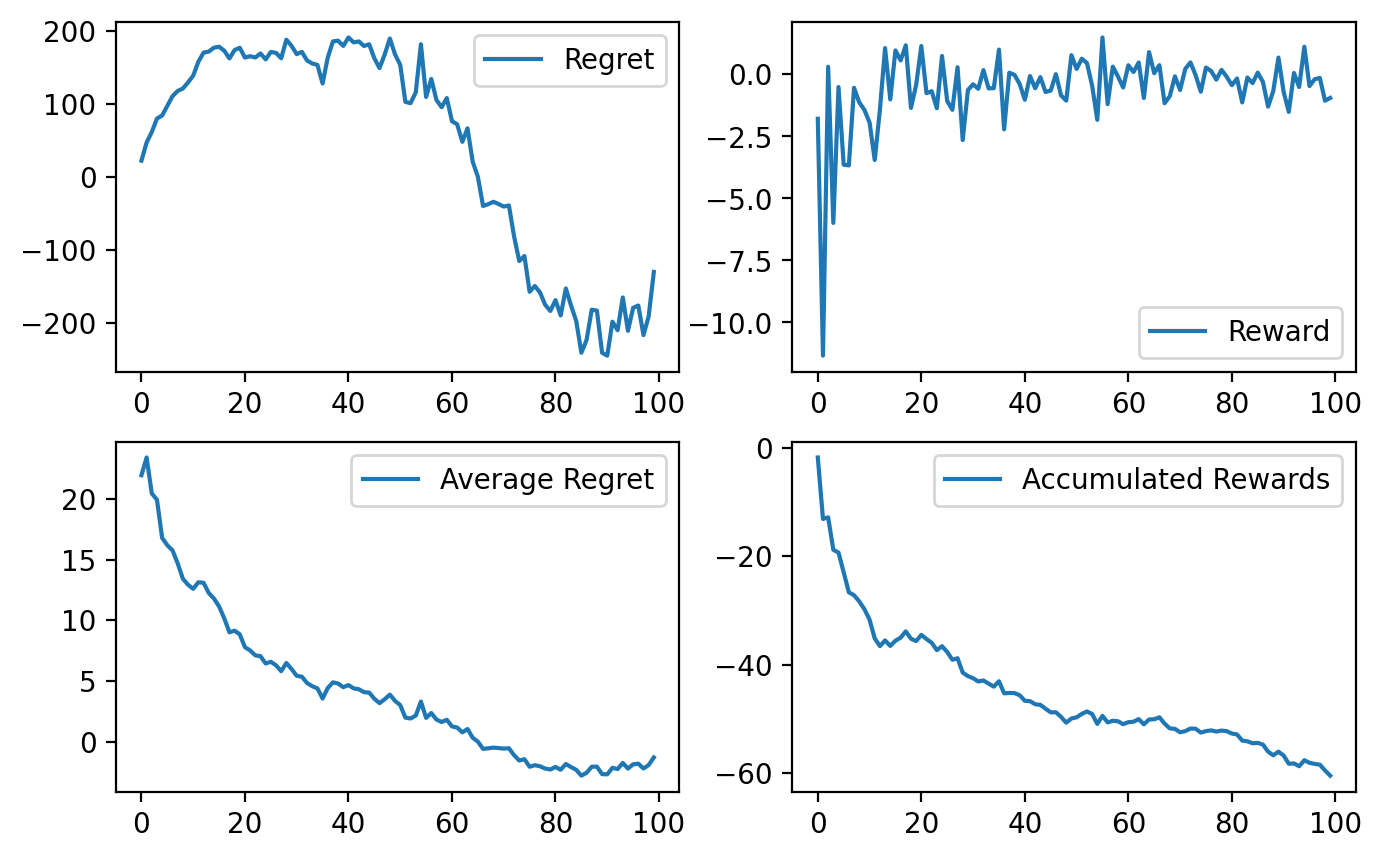

In [110]:
fig, ax = plt.subplots(2, 2, figsize = (8, 5), dpi = 200)

sns.lineplot(df[["Regret"]], ax = ax[0][0]);
sns.lineplot(df[["Reward"]], ax = ax[0][1]);
sns.lineplot(df[["Average Regret"]], ax = ax[1][0]);
sns.lineplot(df[["Accumulated Rewards"]], ax = ax[1][1]);